In [ ]:
import numpy as np
import matplotlib.pyplot as plt

## Motivation ##

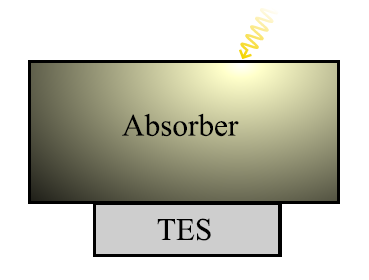

The above figure illustrates a single gamma ray detector. The detector consists of an absorber and a transition edge sensor, or TES. A TES uses the transition between a superconductive and normal state to make very precise temperature measurements. When a photon hits the absorber, it causes a brief spike in the temperature, which is measured by the TES. The amplitude of this spike can be used to determine the energy of the photon.

One difficulty associated with developing these devices is that the particular photon absorption location may affect the magnitude of the temperature spike. This can result in an error in the energy reading. However, a difference in strike location may also affect the shape of the temperature spike. I wondered whether the difference in shape could be used to correct the error in the energy reading.

The goal of this project is to simulate the heat signatures of photon strikes at different locations in order to determine how strike location affects the height and shape of the temperature spikes.

## Mathematics Used in the Simulation ###
### Heat Equation ###
Our first task is to simulate the flow of heat in a solid.

The heat flow equation is:

$$ \frac{\partial u}{\partial t} = \frac{K}{C\rho}\nabla^2 u $$

$$ = \frac{K}{C\rho} \Big(\frac{\partial^2 u}{\partial x^2}
+ \frac{\partial^2 u}{\partial y^2}
+ \frac{\partial^2 u}{\partial z^2}\Big) $$

Where $u$ is the temperature, $K$ is the thermal conductivity, $C$ is the specific heat, and $\rho$ is the density. For brevity, I will define $A = \frac{K}{C\rho}$.

We solve this using a timestep algorithm.

### Discretized Version ###
At a given point $u_i(t_{i})$, the spatial derivatives can be expressed in discrete form:
$$ \frac{\partial^2 u}{\partial x^2} = \frac{u_{i+1} - 2u_i + u_{i-1}}{\Delta x^2} $$

And the time derivative can be expressed as:
$$ \frac{\partial u}{\partial t} = \frac{u(t_{n+1}) - u(t_n)}{\Delta t} $$

Given a particular temperature distribution, we may find the next iteration using the following time step equation:

$$ u_{i,j,k}(t_{n+1}) = u_{i,j,k}(t_n)
 + A\Big(
         \frac{u_{i+1,j,k} - 2u_{i,j,k} + u_{i-1,j,k}}{\Delta x^2}
         + \frac{u_{i,j+1,k} - 2u_{i,j,k} + u_{i,j-1,k}}{\Delta y^2}
         + \frac{u_{i,j,k+1} - 2u_{i,j,k} + u_{i,j,k-1}}{\Delta z^2}
    \Big) \Delta t $$

If we take the same spatial step size for each dimension, we may simplify the expression in parentheses:
$$ \Big(u_{i+1,j,k} + u_{i,j+1,k} + u_{i,j,k+1} + u_{i-1,j,k} + u_{i,j-1,k} + u_{i,j,k-1} - 6u_{i,j,k}\Big)
\cdot\frac{1}{\Delta x^2}
$$
$$
= \frac{1}{\Delta x^2} \bigg(\sum_{adjacent} u(t_n) - 6u_{i,j,k}(t_n)\bigg)
$$

Thus, we have the following equation for determining the next step in the simulation:
$$ u_{i,j,k}(t_{n+1}) = u_{i,j,k}(t_n) +
A\frac{\Delta t}{\Delta x^2} \bigg(\sum_{adjacent} u(t_n) - 6u_{i,j,k}(t_n)\bigg)
$$

To handle an insulated boundary, we introduce fictional points such that the derivative will always be zero. As a simplified case, we assume that the non-insulated boundaries are in perfect thermal contact with a heat sink at a constant temperature.

#### Stability ####

Note that the stability of this function depends on the factor $A \Delta t / \Delta x^2$ being small. For a given material and a given spatial resolution, this means that the time division should satisfy $\Delta t < A \Delta x^2$.


## Python Implementation ##

### First step: Boundary Conditions ###

For the insulated boundaries, the fictional points are just outside the boundary and have the same temperature as the boundary.

For non-insulated boundaries, the fictional points are held at a fixed temperature (the same temperature as the heat bath).

Below is a function that updates the fictional points. 


In [ ]:
def updateBoundary(T, T_ext, btype=(1,0,0,0,0,0)):
    """
    Updates the fictional points for the thermal conductor using
    a set of boundary conditions.
    
    The NumPy array is modified in-place.
    
    Arguments:
    ---------
    - T: a 3d array of temperatures within the solid. The shape of the
         array must be (h+1, w+2, d+2) to include the fictional points
         on 5 of the 6 surfaces.
         
    - T_ext: Temperature of the external environment. This may be either
        a scalar or an array. If it is an array, then the external
        temperatures at the 6 surfaces may be specified separately.
        The surfaces must be listed in the order (x0, x1, y0, y1, z0, z1)
        where x0 is the surface with the first index equal to zero, x1 is the
        surface opposite x0, and likewise for the other 4 surfaces.
    
    - btype: Array-like with the boundary types for the 6 surfaces.
        A value of 1 represents perfectly conducting and 0 represents
        perfectly insulating. Any value other than 0 or 1 will yield
        a linear combination of the two types.
        The surfaces are listed in the same order described above.
        
    Returns:
    ------
    Nothing
    
    """
    # Convert T_ext into an array. If it is already an array,
    # no change will occur.
    T_ext = np.ones(6)*T_ext
    
    # For a thermally conductive surface, the fictional points
    # have the temperature of the surroundings. For an insulating
    # surface, the fictional points have the same temperature as the
    # real points that they are in contact with.
    T[0,:,:] = T_ext[0]*btype[0] + T[1,:,:]*(1-btype[0])
    T[-1,:,:] = T_ext[1]*btype[1] + T[-2,:,:]*(1-btype[1])
    T[:,0,:] = T_ext[2]*btype[2] + T[:,1,:]*(1-btype[2])
    T[:,-1,:] = T_ext[3]*btype[3] + T[:,-2,:]*(1-btype[3])
    T[:,:,0] = T_ext[4]*btype[4] + T[:,:,1]*(1-btype[4])
    T[:,:,-1] = T_ext[5]*btype[5] + T[:,:,-2]*(1-btype[5])
    
    # Modifications occur in place so no need to return anything.
    return
    

### Second Step: Simulation ###

The next functions simulate the flow of heat in a solid.

In [ ]:
def thermalStep(T, dx, dt, A):
    """
    Makes one timestep for simulating the diffusion of heat
    through a solid, given an initial temperature distribution,
    assuming a cyclic boundary. If the boundary is not cyclic,
    the caller must independently update the boundaries
    of the returned array.
    
    The array is modified in-place.
    
    Arguments:
    ---------
    - T: a 3D NumPy array containing the initial temperature distribution,
        to be modified in-place.
    
    - dx: the separation in cm between adjacent points in the solid.
    
    - A: the ratio K/(C*rho) where K is the conductivity, C is the specific
        heat capacity, and rho is the density.
    
    - T_ext: Temperature of the external environment. This may be either
        a scalar or an array. If it is an array, then the external
        temperatures at the 6 surfaces may be specified separately.
        The surfaces must be listed in the order (x0, x1, y0, y1, z0, z1)
        where x0 is the surface with the first index equal to zero, x1 is the
        surface opposite x0, and likewise for the other 4 surfaces.
        
    Returns:
    -------
    Nothing
    
    
    """
    # Calculate the sum of adjacent points
    T_sum = np.roll(T, -1, axis=0) + np.roll(T, 1, axis=0) \
          + np.roll(T, -1, axis=1) + np.roll(T, 1, axis=1) \
          + np.roll(T, -1, axis=2) + np.roll(T, 1, axis=2)
    
    # Calculate the change in temperature
    deltaT = A*(T_sum - 6*T)/(dx**2) * dt
    
    # Add the change in temperature to the original array
    T += deltaT
    
    # Nothing to return - the array was modified in-place.
    return
    
    
def thermalSimulate(T, t, substeps=1, dx=0.1, A=1, T_ext=0, btype=(1,0,0,0,0,0)):
    """
    Simulates the diffusion of heat through a solid given an initial
    temperature distribution and boundary conditions. Simulation
    timesteps are saved at specified times. Additional unsaved
    simulation steps may take place between the saved steps if
    specified by the `substeps` parameter.
    
    Note that a perfectly conducting boundary will not in fact
    result in an edge temperature exactly equal to the external
    temperature. The algorithm creates a set of "fictional points"
    just outside the limits of the solid, and enforces boundary
    conditions only on those points.
    
    Arguments:
    ---------
    - T: a 3D NumPy array containing the initial temperature distribution.
         
    - t: an array containing the times to be saved. Should have uniform separation.
        
    - substeps: Number of simulation timesteps for each time interval given
        in the `t` parameter. If more than 1, the times will be subdivided and
        additional simulation steps will be taken (but not saved).
        Default: 1
    
    - dx: the separation in cm between adjacent points in the solid.
        Default: 0.1 cm
    
    - A: the ratio K/(C*rho) where K is the conductivity, C is the specific
        heat capacity, and rho is the density.
        Default: 1
    
    - T_ext: Temperature of the external environment. This may be either
        a scalar or an array. If it is an array, then the external
        temperatures at the 6 surfaces may be specified separately.
        The surfaces must be listed in the order (x0, x1, y0, y1, z0, z1)
        where x0 is the surface with the first index equal to zero, x1 is the
        surface opposite x0, and likewise for the other 4 surfaces.
        Default: 0
        
    - btype: Array-like with the boundary types for the 6 surfaces.
        A value of 1 represents perfectly conducting and 0 represents
        perfectly insulating. Any value other than 0 or 1 will yield
        a linear combination of the two types.
        The surfaces are listed in the same order described above.
        Default: (1, 0, 0, 0, 0, 0)
    
    
    Returns:
    -------
    - simulation: a 4D NumPy array containing only the saved results of the
         simulation, with the first three indices corresponding to
         the spatial coordinates, and the fourth index corresponding
         to the time.
    
    """
    
    # Find the timestep, assuming uniform times
    dt = (t[1]-t[0]) / substeps
    
    # Modify the array to include fictional points
    currentT = np.zeros(np.array(T.shape)+2)
    currentT[1:-1,1:-1,1:-1] = T
    
    # Make an empty array with an extra axis for time
    simulation = np.zeros(T.shape + (len(t),))
    
    # Add the first frame
    simulation[:,:,:,0] = T
    
    # Iterate!
    for step in range(1,len(t)):
        for substep in range(substeps):
            # Update the boundary of our array
            updateBoundary(currentT, T_ext, btype=btype)
            
            # Take a step in the simulation
            thermalStep(currentT, dx, dt, A)
        
        # Add the last substep to the simulation
        simulation[:,:,:,step] = currentT[1:-1,1:-1,1:-1]
    
    return simulation

### Step 3: Testing the Simulator ###

We carry out a simple test: if the solid begins at a temperature different from the heat bath, will the temperature equalize?

In [ ]:
# Initial temperature 0K
T = np.zeros((11, 11, 11))

# Time span of 2 seconds
t=np.linspace(0, 2, 50)

# Simulate with an external temperature of 10 K
sim = thermalSimulate(T, t, T_ext=10, substeps=10)


In [ ]:
# Display a cross section from the middle of the solid
# observed at the end of the simulation
plt.imshow(sim[:,5,:,-1])
plt.title("Temperature in Cross-Section")
plt.figure()
# Plot the temperature from the insulated to the
# non-insulated end
plt.title("Position Graph")
plt.plot(sim[:,5,5,-1])
plt.ylim(0,10)
plt.xlim(0,10)
plt.xlabel("Depth")
plt.ylabel("Temperature")
# plt.gca().set_aspect('equal')
plt.figure()

For the next test, we will simulate the temperature flow in a conductor that is conductive at opposite ends, and insulated everywhere else. The conductive ends will be held at different temperatures. The final steady-state temperature of the solid should be linear.

In [ ]:
# Initial temperature 0K
T = np.zeros((11, 11, 11))

# Time span of 2 seconds
t=np.linspace(0, 2, 1000)

# Simulate with an external temperature of 1 K
sim = thermalSimulate(T, t, T_ext=(1, 0, 0, 0, 0, 0), btype=(1, 1, 0, 0, 0, 0))
# sim = thermalSimulate(T, t, T_ext=10)

# Display a cross section from the middle of the solid
# observed at the end of the simulation
plt.imshow(sim[:,5,:,-1])
plt.title("Temperature in Cross-Section")
plt.figure()
# Plot the temperature from the insulated to the
# non-insulated end
plt.title("Temperature Graph")
plt.plot(sim[:,5,5,-1])
plt.ylim(0,1)
plt.xlim(0,10)
plt.xlabel("Depth")
plt.ylabel("Temperature")
# plt.gca().set_aspect('equal')
plt.figure()

For the final test, we run the simulator using the values for a real substance, and consider whether the timescale looks reasonable qualitatively. I'll use a cube of tin measuring 1 mm across. Since this is just a qualititive test, I'll grab the properties of tin from a quick Google search.

Specific heat capacity: 0.2177 J/(g$\cdot^{\circ}$C) [\[ref\]](https://www.engineersedge.com/materials/specific_heat_capacity_of_metals_13259.htm) \
Density: 5.769 g/cm$^3$  [\[ref\]](https://en.wikipedia.org/wiki/Tin) \
Thermal conductivity: 66.8 W/(m$\cdot$K) = 0.668 W/(cm$\cdot$K) [\[ref\]](https://en.wikipedia.org/wiki/Tin)

This gives CR = 1.256 J/(cm$^3 \cdot ^{\circ}$C).

I'll give the cube an initial temperature of 4 K and expose it to a heat bath of 10 K. I'll pick a timestep that will make the simulation stable. Then I'll run the simulation for 1000 steps. At the end of the simulation I'll plot both the temperature with respect to depth, and the temperature at the center of the cube with respect to time.

In [ ]:
# Initial temperature 4K
T = np.ones((11, 11, 11))*4

# Parameters
K = 0.668 # Thermal conductivity
CR = 1.256 # Specific heat times density
tin_A = K/CR # Calculate the ratio
dx = 1e-4 # Cube side length


# Pick a more stable timestep
dt = 0.1*dx**2/tin_A

t=np.arange(0, dt*1000, dt)

# Simulate with an external temperature of 10 K
# sim = thermalSimulate(T, t, T_ext=10, CR=1.256, K=66.8, dx=0.0001)

sim = thermalSimulate(T, t, T_ext=10, A=tin_A, dx=dx)

In [ ]:
# Plot the temperature from the insulated to the
# non-insulated end
plt.plot(np.linspace(0, 1, 11), sim[:,5,5,-1])
plt.ylim(0,10.1)
plt.xlim(0,1)
plt.xlabel("Depth (mm)")
plt.ylabel("Temperature (K)")
plt.figure()

# Extract a time-graph of the temperature at the middle of the cube
timecurve = sim[5,5,5,:]
plt.plot(t, timecurve)
plt.xlabel("Time (s)")
plt.ylabel("Temperature (K)")

The timescale is on the order of microseconds, which seems reasonable if such a small object is given perfect thermal contact to a heat bath on one of its surfaces.

### Step 4: Photon Absorption ###

After verifying that the simulator produces expected results, we now simulate photon absorption events.

First, I simulate a single event. I assume that an energetic photon is absorbed by one of the units in the solid, and then simulate the resulting heat dissipation. I include a function that produces a temperature/time plot for a particular location within the solid as the heat dissipates.

In [ ]:
dx = 1.6e-3/11 # Distance between each point

# Pick a stable timestep
dt = 0.1*dx**2/tin_A
t=np.arange(0, dt*1000, dt)

# Initial temperature 0K
T = np.ones((7, 11, 11))*0

# Energy of photon: 100 keV = 1.6e-14 J
E = 1.6e-14

# Temperature change from photon: energy divided by heat capacity
# of a single unit
deltaT = E/(CR * dx**3)

T[-1,5,5] = deltaT

# Simulate with an external temperature of 0 K
sim = thermalSimulate(T, t, A=tin_A, T_ext=0, dx=dx)

In [ ]:
t_signature = sim[1,5,5,:]
plt.plot(t,t_signature)
plt.xlabel("Time (s)")
plt.ylabel("Temperature (K)")
plt.title("100keV photon absorption event\nin 1x1.6x1.6 mm block of tin")

#### Function for generating a temperature curve ####

Below is a function to generate the temperature curve for a single photon absorption event. The function will take an array containing the initial temperature distribution and will simulate the effect of a single absorbed photon, assuming that only the base of the absorber is in thermal contact with a heat bath.

In [ ]:
def getSignature(T, p_loc, sensor_loc=None, p_temp=100., steps=200, dx=0.1, A=1,
                  T_ext=0., substeps=5):
    """
    Simulate a photon absorption event for an absorber and return
    the temperature curve measured by a point sensor located at
    a given position within the absorber. The absorber has a base
    that is in perfect thermal contact with the heat bath, and
    the remaining surfaces are insulated.
    
    Arguments:
    ---------
    - T: A 3D NumPy array with the initial temperature distribution for
        the absorber.
    
    - p_loc: Tuple containing the coordinates of the location where
        the photon was absorbed.
        
    - sensor_loc: Tuple with the coordinates of the temperature sensor.
        If none, the location will be at the center of the bottom
        surface (or at the point with indices rounded down, if there
        is no exact center).
        Default: None
    
    - p_temp: The temperature difference caused by the absorbed
        photon.
        Default: 100.0
        
    - steps: Number of temperature measurements.
        Default: 100
    
    - substeps: Number of simulation steps before each temperature
        measurement.
        Default: 5
    
    - dx: The spacing between points in the temperature array.
        Default: 0.1
        
    - A: The ratio K/(C*rho) in units of (T*d^2)/t where K is
        the conductivity, C is the specific heat, and rho is the
        mass density of the absorber.
        Default: 1
        
    - T_ext: The temperature of the external heat bath.
        Default: 0
    
    Returns:
    -------
    - t: An array of times for the temperature measurements
    
    - signature: The measured temperatures 
    
    """
    # Calculate the time between measurements, and
    # construct the time array
    dt = 0.1*dx**2/A * substeps
    t = np.arange(0, dt*steps, dt)
    
    # If the sensor location was not specified, default to
    # the base at the center
    if sensor_loc == None:
        sensor_loc = (0, T.shape[1]//2, T.shape[2]//2)
    
    # Copy the temperature array to avoid overwriting the original
    newT = T.copy()
    newT[p_loc[0], p_loc[1], p_loc[2]] += p_temp
    
    # Simulate!
    sim = thermalSimulate(newT, t, substeps=substeps, T_ext=T_ext, A=A, dx=dx)
    
    # Pull the signature from the simulation data
    signature = sim[sensor_loc[0],sensor_loc[1],sensor_loc[2],:]
    
    return t, signature

#### Testing the getSignature Function ####
As a brief test of the `getSignature` function, I reproduce the plot from part 3 for the temperature in a tin block. I do this using a photon with zero energy, a heat bath with a temperature of 10 K, and an initial temperature of 4K.


In [ ]:
# Initial temperature 4K
T = np.ones((11, 11, 11))*4
dx = 1e-4 # Cube side length

t, testsig = getSignature(T, (0,0,0), p_temp=0, sensor_loc=(5,5,5), T_ext=10., dx=dx, A=tin_A, steps=1000, substeps=1)
plt.plot(t, testsig)
plt.xlabel("Time (s)")
plt.ylabel("Temperature (K)")

#### Generating signatures for photon strikes at different locations ####

The following cells generate signatures for photon strikes in various locations. We look at two different absorbers: the first is a box measuring 1x1.6x1.6 mm and the second is a 1.6 mm cube. For each absorber type, I made two plots. The first plot compares the signatures for different photon absorption locations. The second plot rescales and offsets the signatures so that the peak amplitude matches up. This makes it possible to compare the shapes of the different signatures.

In [ ]:
"""
    Absorber #1
"""


# Distance between points
dx = 1.6e-3/11

# Photon energy
E = 1.6e-14

# Change in temperature at the strike location
deltaT = E/(CR * dx**3)

# Initial temperature array
T = np.zeros((7,11,11))

# Array to hold the different temperature curves
signatures = [None]*4

# Locations for the different strikes
labels = ("Center", "Corner", "0.8mm Sideways", "0.8mm Diagonal")
locations = ((-1, 5, 5),(-1, 0, 0),(-1, 0, 5),(-1, 2, 1))

# Simulate the four events
for i in range(len(signatures)):
    t, signatures[i] = getSignature(T, locations[i], p_temp=deltaT, steps=200, A=tin_A, dx=dx)

In [ ]:
# Plot the simulated curves
plt.title("Photon strikes at different surface locations\non 1x1.6x1.6 mm block of tin")
for i in range(len(signatures)):
    plt.plot(t, signatures[i], label=labels[i])
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Temperature (K)")
plt.show()

# Rescale the curves and overlap them
plt.title("Rescaled comparison of different strike locations")
# plt.plot(t, signatures[0], label="Center")
for i in range(0,len(signatures)):
    offset = t[np.argmax(signatures[i])]
    rescale = np.max(signatures[0])/np.max(signatures[i])
    plt.plot(t-offset, signatures[i]*rescale, label=labels[i])
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Temperature (K)")
plt.show()

In [ ]:
"""
    Absorber #2
"""

T2 = np.zeros((11,11,11))
signatures = [None]*4
# Same labels and locations as before
for i in range(len(signatures)):
    t, signatures[i] = getSignature(T2, locations[i], p_temp=deltaT, steps=200, A=tin_A, dx=dx)

In [ ]:
plt.title("Photon strikes at different surface locations\non 1.6 mm cube absorber")
for i in range(len(signatures)):
    plt.plot(t, signatures[i], label=labels[i])
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Temperature (K)")
plt.show()

plt.title("Rescaled comparison of different strike locations")
# plt.plot(t, signatures[0], label="Center")
for i in range(0,len(signatures)):
    offset = t[np.argmax(signatures[i])]
    rescale = np.max(signatures[0])/np.max(signatures[i])
    plt.plot(t-offset, signatures[i]*rescale, label=labels[i])
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Temperature (K)")
plt.show()

## Conclusion ##

From the simulated photon strikes above, I conclude that the location of a photon strike does have an effect on the amplitude of the temperature spike. It also has an effect on the shape of the spike, and this change in shape could be useful for correcting the error due to the difference in shape. Further investigation would be necessary in order to determine whether this would be possible in practice.

I also found that the geometry of the absorber can affect the error caused by differences in strike location. Specifically, a cube-shaped absorber is less susceptible to error than a box with a lower depth.